# Assignment 3 – Topic Modeling and Clustering for Online Social Media Data

*Due: Friday January 12 at 14:00 CET*

In the third assignment of the course Applications of Machine Learning (INFOB3APML), you will learn to use topic modeling and clustering to identify topics in online social media data. The objectives of this assignment are:
- understand and process the text data
- use the clustering algorithm to determine clusters in real-life data
- use the Latent Dirichlet Allocation algorithm to identify discussed topics in real-life text data 
- use the visualization tools to validate the results of unsupervised learning and interpret your findings
- reflect on the difference between two type of unsupervised learning algorithms

In this assignment, you are going to discover the different ‘topics’ from a real social media text dataset. The project is divided into two parts (4 subtasks):

- The first part contains data processing (1.1) and feature extraction (1.2) from the raw text data.
- In the second part, you will implement two methods (2.1), a topic modeling method and a clustering method, to identify topics from the processed data. Then, the evaluation will be done by using visualization tools (2.2). 

Provided files:
- The dataset: data/raw_data.txt
- A tutorial notebook showcases some packages you could use for this assignment (optional): Ass3_tutorial.ipynb
- Some sample visualization codes for interpreting the topic results: viz_example.ipynb

In [51]:
import spacy
from spacy.lang.nl.examples import sentences
import io

nlp = spacy.load("nl_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
print()
for token in doc:
    print(token.text)
    # print(token.pos_)
    # print(token.dep_)
    # print('')

Apple overweegt om voor 1 miljard een U.K. startup te kopen

Apple
overweegt
om
voor
1
miljard
een
U.K.
startup
te
kopen


 ## Dataset:
 The data used in this assignment is Dutch text data. We collected the COVID-19 crisis related messages from online social media (Twitter) from January to November 2021. Then, a subset of raw tweets was randomly sampled. In total, our dataset includes the text data of about 100K messages. **To protect the data privacy, please only use this dataset within the course.**

 ## 0. Before you start the Project: 
 The provided messages in the raw dataset were collected based on 10 different themes that relate to the COVID-19 crisis. Here is a list of all themes:
 -	Lockdown
 -	Face mask
 -	Social distancing
 -	Loneliness
 -	Happiness
 -	Vaccine
 -	Testing
 -  Curfew
 -  Covid entry pass
 -  Work from home

Before starting your project, you need to first filter the messages (all messages are in Dutch) and use the messages belonging to only one theme for the topic identification. 
 
If you have submitted the theme preference, you can skip the following paragraph.

*Please notice that there will be maximum two teams working on a same theme. In this way, we hope that each group will develop their own dataset and come up with interesting results.*

 ## 1.1 Data Processing
 In the first part of the assignment, please first filter the messages and use the messages belonging to your allocated theme for the identification of topics. For that you will need to:
 -	Design your query (e.g. a regular expression or a set of keywords) and filter the related messages for your allocated theme. 
 -	Clean your filtered messages and preprocess them into the right representation. Please refer to the text data pre-processing and representation methods discussed in the lecture. You may use some of the recommended packages for text data preprocessing and representation.

In [52]:
# TODO: filter the related messages
RANDOM_SEED = 42
topic_words = ['Eenzaamheid', 'Thuis', 'depressie','verdrietig']

def phase0_open_txt_stream(filename):
    return io.open(filename, "r", encoding="utf-8")

def get_data(max = -1):
    pipe = phase0_open_txt_stream("../others/data/raw_data.txt")
    data = []
    cont = 0
    while (cont != max):
        sentence = nlp(next(pipe))
        if not sentence:
            break
        data.append(sentence)
        cont += 1
    pipe.close()
    return data


In [53]:
data = get_data(1000)

In [54]:
raw_data = list(map(lambda token: token.text, data))
print(raw_data)


["Hahah, het verzet is begonnen. Het knalt hier op z'n best hoor. Voor mijn dieren vind ik het erg, maar f@ck die maffe regering hier. Gelukkig nieuwjaar!\n", 'RT @D66Vught: Het is 2021! https://t.co/LpPuFPuqR8\n', '@MijumewAndCo Happy new year mij!\n', 'Fantastisch dat ik zoveel vuurwerk hoor..... We worden echt wakker yes. En het boeit mij niet wat een ander er van denkt.\\nOp naar een Great Awakening en happy new year 😃🎉🙏❤️\n', 'Gelukkig nieuwjaar allemaal!!!! Binnen exact een maand ben ik jarig en ik hoop dat ik dan eindelijk birthdaySEX kan hebben xxx\n', 'Iedereen in de wereld krijgt aftel momenten bij bruggen, hoge torens of een drone show.\\nSchitterende beelden.\\nin Nederland krijgen we dat afschuwelijke stadion in duivedrecht\\ntezien, en dan vinden we het gek dat iedereen de straat op gaat..\\nAlsof die lockdown niet voldoende is 🙉\n', 'Gelukkig 2021 iedereen! Maar please hou het veilig, want een nieuw jaar betekend niet dat die’n Corona ineens foetsie is eh...\n', 'Ik wens

In [55]:
# TODO: clean and preprocess the messages


In [56]:

# TODO: represent the messages into formats that can be used in clustering or LDA algorithms (you may need different represention for two algorithms)



 ## 1.2 Exploratory Data Analysis
 After preprocessing the data, create at least 2 figures or tables that help you understand the data.

 While exploring the data, you may also think about questions such as:
 - Can you spot any differences between Twitter data and usual text data?
 - Does your exploration reveal some issues that would make it difficult to interpret the topics?
 - Can you improve the data by adding additional preprocessing steps?

In [57]:
# TODO: plot figure(s)


## 2.1 Topic modelling and clustering
 In the second part of the assignment, you will first:
 -	Implement a Latent Dirichlet Allocation (LDA) algorithm to identify the discussed topics for your theme
 -	Implement a clustering method  to cluster messages into different groups, then represent the topic of each cluster using a bag of words

While implementing the algorithms, you may use the codes from the recommended packages. In the final report, please explain reasons to select the used algorithm/package. 

In [58]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

dutch_stopwords = [
    'aan', 'als', 'bij', 'dan', 'dat', 'die', 'dit', 'een', 'en', 'er', 'het',
    'hij', 'hoe', 'hun', 'ik', 'in', 'is', 'je', 'kan', 'maar', 'met', 'mij', 'niet', 'nog',
    'nu', 'of', 'ons', 'ook', 'te', 'tot', 'uit', 'van', 'voor', 'was', 'wat',
    'we', 'wel', 'wij', 'zal', 'ze', 'zei', 'zelf', 'zich', 'zo', 'zij'
]

def get_term_document_matrix(random=None):
    if not random:
        np.random.seed(RANDOM_SEED)
        # 100 documents with 35 words each
        return np.random.rand(1000,35)
    if random == 'tmp':
        from sklearn.feature_extraction.text import CountVectorizer
        tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                        lowercase = True,
                                        stop_words = dutch_stopwords,
                                        token_pattern = r'\b[a-zA-Z]{3,}\b',
                                        max_df = 0.5, 
                                        min_df = 10)
        document_term_matrix = tf_vectorizer.fit_transform(raw_data)
        print(document_term_matrix.shape, len(tf_vectorizer.vocabulary_))
        return document_term_matrix, tf_vectorizer
    
    
def get_word_vector_matrix(random = None):
    if not random:
        np.random.seed(RANDOM_SEED)
        return np.random.rand(3466,4)
        

def get_document_vector_matrix(random = None):
    if not random:
        np.random.seed(RANDOM_SEED)
        return np.random.rand(1000,4)

In [59]:
# TODO: topic modeling using the LDA algorithm

dtm_tf, tf_vectorizer = get_term_document_matrix(random='tmp')
lda_tf = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)

print(dtm_tf[1,:5])
doc_topic = lda_tf.fit_transform(dtm_tf)
print(dtm_tf[1,:5])

print("matrix shape:", dtm_tf.shape)
print("transformed shape: ",doc_topic.shape)
print("example document 1:",doc_topic[1])

(1000, 302) 302


matrix shape: (1000, 302)
transformed shape:  (1000, 5)
example document 1: [0.10206998 0.59529447 0.10000018 0.10209207 0.10054329]


#### 2.2 Genism Method


In [60]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary
# Create a dictionary representation of the documents.
matrix_sentences = [el.split(" ") for el in raw_data]
dictionary = Dictionary(documents=matrix_sentences)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print(dictionary)

Dictionary<152 unique tokens: ['Gelukkig', 'Het', 'Voor', 'die', 'het']...>


In [61]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in matrix_sentences]

In [62]:
dictionary.id2token

{}

In [63]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_SEED
)

In [64]:
# import json
# import numpy as np

# def load_R_model(filename):
#     data = {'topic_term_dists': model.get, 
#             'doc_topic_dists': model.theta,
#             'doc_lengths': data_input['doc.length'],
#             'vocab': data_input['vocab'],
#             'term_frequency': data_input['term.frequency']}
#     return data

# movies_model_data = load_R_model('data/movie_reviews_input.json')

# print('Topic-Term shape: %s' % str(np.array(movies_model_data['topic_term_dists']).shape))
# print('Doc-Topic shape: %s' % str(np.array(movies_model_data['doc_topic_dists']).shape))

### Clustering

In [65]:
word_vector_matrx = get_word_vector_matrix()
word_vector_matrx.shape

(3466, 4)

In [66]:
document_vector_matrx = get_document_vector_matrix()
document_vector_matrx.shape

(1000, 4)

In [67]:
# TODO: cluster the messages using a clustering algorithm

from sklearn.cluster import KMeans

kmeans = KMeans()

clustrer_labels = kmeans.fit_predict(document_vector_matrx)
clustrer_labels.shape, max(clustrer_labels)
kmeans.cluster_centers_[0].shape

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(4,)

In [68]:
def get_k_neares_words(cluster_centers, any_other_word, k=5):
    from sklearn.neighbors import NearestNeighbors
    assert( cluster_centers.shape[1] == any_other_word.shape[1])
    print("Cluster centers shape:", cluster_centers.shape)
    print("Words2vec shape: ",any_other_word.shape)
    
    # Create and fit the nearest neighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(any_other_word)

    # Find the k nearest neighbors for each point in A
    _, indices = nbrs.kneighbors(cluster_centers)
    return indices

get_k_neares_words(kmeans.cluster_centers_, word_vector_matrx)


Cluster centers shape: (8, 4)
Words2vec shape:  (3466, 4)


array([[2775, 3026, 1143, 3071, 2875],
       [ 359,  735, 1239, 1937,  993],
       [2221, 1570,   69, 1087, 2702],
       [1975,  905, 2054, 1240,  232],
       [ 517,   21, 1641, 3192, 1249],
       [3161, 3163,  487, 1305, 3313],
       [1508, 1003,  221,  840, 2350],
       [3447, 2128, 3201, 1555,  761]])

In [69]:
import pandas as pd

#Embedded as the average of words that is composed of
df = pd.DataFrame(dtm_tf.toarray())
df['cluster'] = clustrer_labels
df

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,300,301,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
996,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,7
997,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,5
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6


In [70]:
aggregated_clusters = df.groupby('cluster').sum()
aggregated_clusters

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
cluster,,,,,,,,,,,,,,,,,,,,,
0,2,0,0,7,1,1,3,3,1,2,...,2,4,26,3,4,1,4,3,4,3
1,2,6,5,10,4,3,0,2,1,1,...,0,3,38,6,5,2,1,3,3,1
2,2,2,8,5,1,4,5,1,2,2,...,1,4,23,1,1,5,3,2,11,2
3,2,4,5,7,2,2,5,2,3,1,...,2,3,26,0,1,1,3,3,3,0
4,0,6,4,10,0,4,6,1,2,3,...,0,2,25,2,1,1,0,2,9,2
5,0,4,5,5,5,1,5,2,0,3,...,2,1,31,6,1,3,4,2,4,1
6,1,5,1,9,5,2,3,3,2,2,...,1,0,33,2,1,2,3,2,5,1
7,1,1,3,8,5,3,4,0,1,2,...,2,4,24,3,1,2,1,1,3,0


In [76]:
bag_dimension = 10

top_columns = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).index.tolist(), axis=1)
top_scores = aggregated_clusters.apply(lambda row: row.nlargest(bag_dimension).values.tolist(), axis=1)
print(top_columns)
print(top_scores)

cluster
0    [100, 294, 137, 43, 151, 164, 266, 153, 37, 88]
1     [294, 100, 64, 151, 86, 149, 197, 43, 62, 137]
2     [100, 294, 88, 24, 43, 64, 164, 239, 151, 145]
3    [100, 294, 64, 164, 151, 61, 86, 153, 197, 281]
4      [100, 294, 151, 64, 137, 88, 24, 149, 46, 14]
5    [100, 294, 239, 88, 151, 164, 197, 64, 266, 86]
6    [100, 294, 239, 64, 24, 164, 153, 132, 46, 282]
7     [100, 294, 151, 64, 239, 43, 164, 86, 88, 109]
dtype: object
cluster
0    [44, 26, 18, 17, 17, 16, 14, 13, 12, 12]
1    [38, 37, 22, 17, 15, 14, 14, 12, 12, 12]
2    [54, 23, 20, 19, 17, 17, 16, 15, 13, 12]
3    [42, 26, 19, 13, 12, 11, 11, 11, 11, 11]
4    [46, 25, 22, 21, 18, 15, 14, 14, 13, 12]
5    [45, 31, 24, 23, 23, 17, 14, 13, 13, 12]
6    [42, 33, 20, 19, 17, 16, 15, 13, 12, 12]
7    [43, 24, 22, 21, 18, 17, 17, 15, 15, 15]
dtype: object


In [154]:
feature_names = tf_vectorizer.get_feature_names_out()
dictionaries = [{key: float(value) for key, value in dict(zip(feature_names[top_columns_single], top_scores_single)).items()} for top_columns_single, top_scores_single in zip(top_columns, top_scores)]
dictionaries

[{'https': 44.0,
  'zijn': 26.0,
  'lockdown': 18.0,
  'door': 17.0,
  'mensen': 17.0,
  'naar': 16.0,
  'weer': 14.0,
  'mijn': 13.0,
  'deze': 12.0,
  'heeft': 12.0},
 {'zijn': 38.0,
  'https': 37.0,
  'geen': 22.0,
  'mensen': 17.0,
  'hebben': 15.0,
  'meer': 14.0,
  'over': 14.0,
  'door': 12.0,
  'gaat': 12.0,
  'lockdown': 12.0},
 {'https': 54.0,
  'zijn': 23.0,
  'heeft': 20.0,
  'corona': 19.0,
  'door': 17.0,
  'geen': 17.0,
  'naar': 16.0,
  'vaccin': 15.0,
  'mensen': 13.0,
  'mag': 12.0},
 {'https': 42.0,
  'zijn': 26.0,
  'geen': 19.0,
  'naar': 13.0,
  'mensen': 12.0,
  'gaan': 11.0,
  'hebben': 11.0,
  'mijn': 11.0,
  'over': 11.0,
  'worden': 11.0},
 {'https': 46.0,
  'zijn': 25.0,
  'mensen': 22.0,
  'geen': 21.0,
  'lockdown': 18.0,
  'heeft': 15.0,
  'corona': 14.0,
  'meer': 14.0,
  'dus': 13.0,
  'ben': 12.0},
 {'https': 45.0,
  'zijn': 31.0,
  'vaccin': 24.0,
  'heeft': 23.0,
  'mensen': 23.0,
  'naar': 17.0,
  'over': 14.0,
  'geen': 13.0,
  'weer': 13.0,
  'heb

In [155]:
nested_dictionary = {i:dictionary_single for i,dictionary_single in enumerate(dictionaries)}
nested_dictionary

{0: {'https': 44.0,
  'zijn': 26.0,
  'lockdown': 18.0,
  'door': 17.0,
  'mensen': 17.0,
  'naar': 16.0,
  'weer': 14.0,
  'mijn': 13.0,
  'deze': 12.0,
  'heeft': 12.0},
 1: {'zijn': 38.0,
  'https': 37.0,
  'geen': 22.0,
  'mensen': 17.0,
  'hebben': 15.0,
  'meer': 14.0,
  'over': 14.0,
  'door': 12.0,
  'gaat': 12.0,
  'lockdown': 12.0},
 2: {'https': 54.0,
  'zijn': 23.0,
  'heeft': 20.0,
  'corona': 19.0,
  'door': 17.0,
  'geen': 17.0,
  'naar': 16.0,
  'vaccin': 15.0,
  'mensen': 13.0,
  'mag': 12.0},
 3: {'https': 42.0,
  'zijn': 26.0,
  'geen': 19.0,
  'naar': 13.0,
  'mensen': 12.0,
  'gaan': 11.0,
  'hebben': 11.0,
  'mijn': 11.0,
  'over': 11.0,
  'worden': 11.0},
 4: {'https': 46.0,
  'zijn': 25.0,
  'mensen': 22.0,
  'geen': 21.0,
  'lockdown': 18.0,
  'heeft': 15.0,
  'corona': 14.0,
  'meer': 14.0,
  'dus': 13.0,
  'ben': 12.0},
 5: {'https': 45.0,
  'zijn': 31.0,
  'vaccin': 24.0,
  'heeft': 23.0,
  'mensen': 23.0,
  'naar': 17.0,
  'over': 14.0,
  'geen': 13.0,
  'w

In [190]:
topic_id = pd.DataFrame(columns=['topic_id'], data=np.arange(0,nested_dictionary.__len__()))
topic_id


,topic_id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


 ## 2.2 Results, evaluation and Interpretation 
 
Finally, you will describe, evaluate and interpret your findings from two methods. 

- In the report, you need to describe and discuss the similarity and difference of results from two methods.
- While evaluating the results, human judgment is very important, so visualization techniques are helpful to evaluate the identified topics in an interpreted manner. 
    
1. For evaluating the topic modelling algorithm, please first use the interactive tool **[pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=)** to examine the inter-topic separation of your findings. 

2. For interpreting the identified topics / clusters of both algorithms, we provide example code for several visualization techiques. You can use multiple ones to evaluate your results or come up with visualisations on your own. The files contain examples for how to use the visualisation functions.


In [73]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

pyLDAvis.lda_model.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.117083  0.106886       1        1  25.021337
0      0.072652  0.096361       2        1  24.060607
4      0.036011 -0.218794       3        1  20.790041
1      0.101198 -0.015306       4        1  16.223797
2     -0.326944  0.030853       5        1  13.904218, topic_info=       Term        Freq       Total Category  logprob  loglift
88    heeft  113.000000  113.000000  Default  30.0000  30.0000
100   https  338.000000  338.000000  Default  29.0000  29.0000
239  vaccin  115.000000  115.000000  Default  28.0000  28.0000
132   laten   68.000000   68.000000  Default  27.0000  27.0000
153    mijn   82.000000   82.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
61     gaan   29.312888   75.516565   Topic5  -3.6919   1.0267
263    want   20.953944   51.505437   Topic5  -4.0276   1.0736
24   corona   33.351463   98.184110   Topic5  -3.5628   0.8932
266    weer   24.591104   73.617286   Topic5  -3.8675   0.8765
164    naar   27.111196  112.606362   Topic5  -3.7699   0.5490

[260 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         3  0.958275  afstand
3         1  0.252097   alleen
3         2  0.201677   alleen
3         3  0.453774   alleen
3         4  0.100839   alleen
...     ...       ...      ...
299       3  0.111172     zorg
300       1  0.538662      zou
300       2  0.293815      zou
300       3  0.122423      zou
300       4  0.048969      zou

[449 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

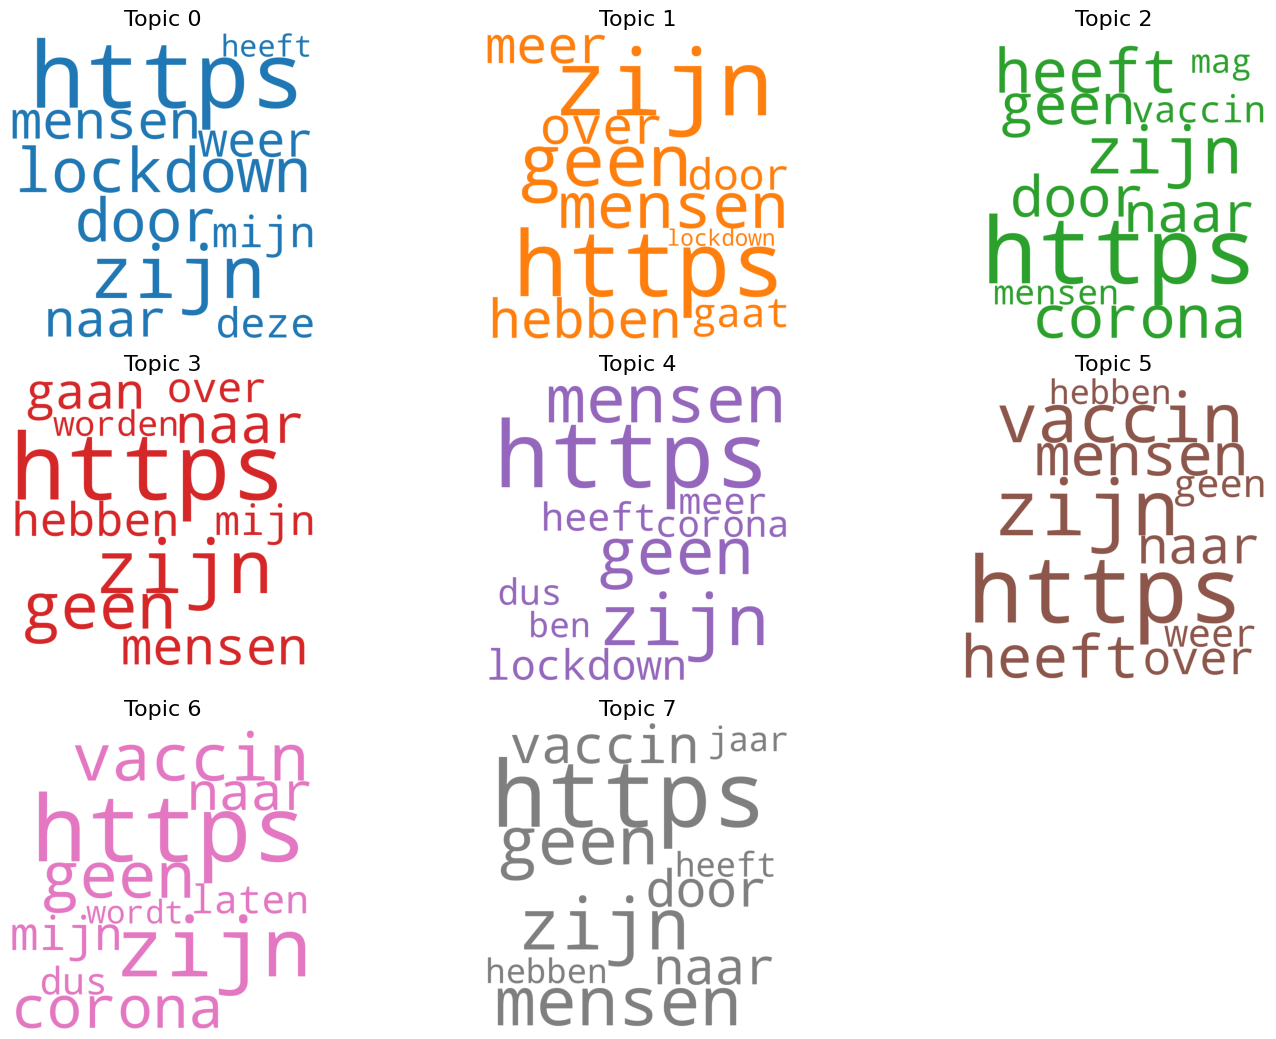

In [193]:
import sys
sys.path.insert(1, '../others')

from viz import show_sentences, show_top_k_topics, show_topic_distributions, show_topic_weights_and_counts, show_topic_wordclouds, show_wordcounts_and_topics
show_topic_wordclouds(df_dominant_topics=topic_id, topics=nested_dictionary)



# Bonus Tasks 

We would like to challenge you with the following bonus task. For each task that is successfully completed, you may obtain max. 1 extra point. 

1. Implement another clustering algorithm or design your own clustering algorithm. Discuss your findings and explain why this is a better (or worse) clustering algorithm than the above one (the clustering algorithm, not LDA).

2. Can you think of other evaluation methods than the provided visualization techniques? If so, implement one and explain why it is a good evaluation for our task.